<a href="https://colab.research.google.com/github/dk-wei/nlp-topic-modeling/blob/main/Topic_Modeling_with_BERT_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Steps will be covered in this [Notebook](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6):

- creat embedding 
- dim reduction 
- clustering 
- creat topic for each cluster (class-based tf-idf)
- topic reduction

In [ ]:
!pip install -U sentence-transformers
!pip install hdbscan
!pip install bertopic

In [2]:
import pandas as pd

# Data & Packages

For this example, we use the famous `20 Newsgroups` dataset which contains roughly 18000 newsgroups posts on 20 topics. Using Scikit-Learn, we can quickly download and prepare the data:

In [3]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

NOTE: If you want to apply topic modeling not on the entire document but on the paragraph level, I would suggest splitting your data before creating the embeddings.

In [4]:
len(data), data[0]

(18846,
 "From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n")

In [5]:
#data = data[:1000]

# Embeddings

The very first step we have to do is converting the documents to numerical data. We use **BERT** for this purpose as it extracts different embeddings based on the context of the word. Not only that, there are many pre-trained models available ready to be used.

How you generate the BERT embeddings for a document is up to you. However, I prefer to use the `sentence-transformers` package as the resulting embeddings have shown to be of high quality and typically work quite well for document-level embeddings.

Install the package with pip install sentence-transformers before generating the document embeddings. If you run into issues installing this package, then it is worth installing Pytorch first.

Then, run the following code to transform your documents in 512-dimensional vectors:

**Note:** pLease turn `GPU` on if available, this will hugely decrease encodig time

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

100%|██████████| 245M/245M [00:15<00:00, 16.0MB/s]


We are using `Distilbert` as it gives a nice balance between speed and performance. The package has several multi-lingual models available for you to use.

NOTE: Since transformer models have a token limit, you might run into some errors when inputting large documents. In that case, you could consider splitting documents into paragraphs.

In [7]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('paraphrase-distilroberta-base-v1')
# embeddings = model.encode(data, show_progress_bar=True)

In [8]:
embeddings

array([[ 0.20808756, -0.2954852 ,  0.42034993, ...,  0.22280718,
         0.20041373,  0.3248372 ],
       [-0.45603922, -0.36920026,  0.55764884, ...,  0.5806512 ,
         0.23162335, -0.80860126],
       [-0.52238715, -0.3920858 , -0.3951975 , ..., -0.43376952,
         0.5196806 , -0.30271947],
       ...,
       [ 0.12062718, -0.44312248,  0.2343158 , ...,  0.5020765 ,
        -0.24836956, -0.18186815],
       [-0.68594915,  0.20820905,  1.1398734 , ..., -0.169808  ,
         0.5687996 ,  0.25218046],
       [-0.31797165, -0.04682334, -0.29690537, ...,  0.15590712,
         0.1624033 , -0.33358774]], dtype=float32)

# Clustering

We want to make sure that documents with similar topics are clustered together such that we can find the topics within these clusters. Before doing so, we first need to lower the dimensionality of the embeddings as **many clustering algorithms handle high dimensionality poorly**.

## UMAP (Dim Reduction)

Out of the few dimensionality reduction algorithms, UMAP is arguably the best performing as it keeps a significant portion of the high-dimensional local structure in lower dimensionality.

Install the package with pip install umap-learn before we lower the dimensionality of the document embeddings. We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can play around with these values to optimize for your topic creation. **Note that a too low dimensionality results in a loss of information while a too high dimensionality results in poorer clustering results.**

In [9]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

## HDBSAN (Clustering)

After having reduced the dimensionality of the documents embeddings to 5, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Moreover, HDBSCAN does not force data points to clusters as it considers them outliers.

Install the package with pip install hdbscan then create the clusters:


In [10]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Great! We now have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

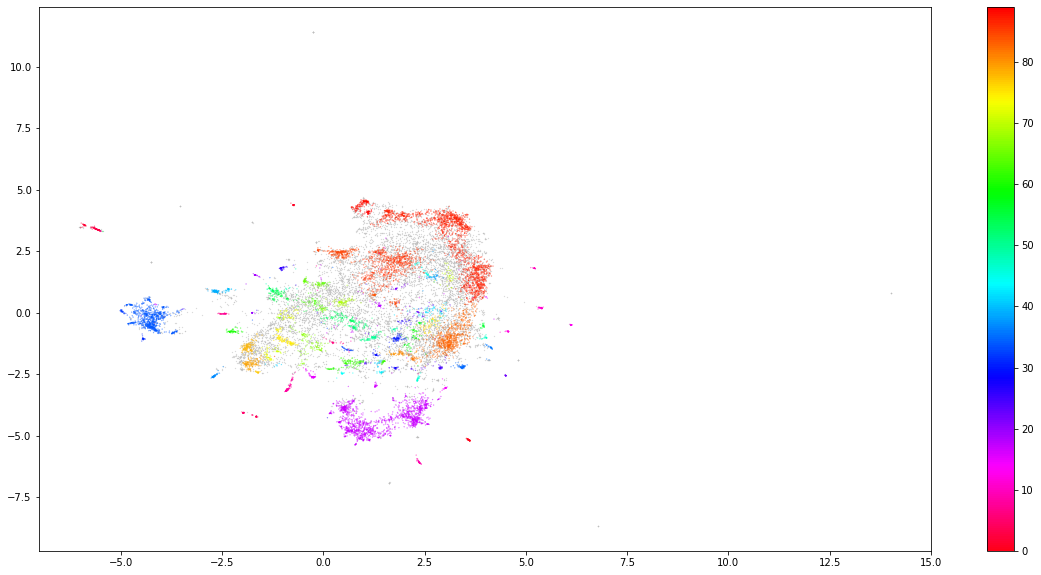

In [19]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s= 0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

It is difficult to visualize the individual clusters due to the number of topics generated (~55). However, we can see that even in 2-dimensional space some local structure is kept.

NOTE: You could skip the dimensionality reduction step if you use a clustering algorithm that can handle high dimensionality like a cosine-based k-Means.


## Topic Creation

What we want to know from the clusters that we generated, is **what makes one cluster, based on their content, different from another**?

>How can we derive topics from clustered documents?

To solve this, I came up with a class-based variant of TF-IDF (c-TF-IDF), that would allow me to extract what makes each set of documents unique compared to the other.

The intuition behind the method is as follows. When you apply TF-IDF as usual on a set of documents, what you are basically doing is comparing the importance of words between documents.

What if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be a very long document per category and the resulting TF-IDF score would demonstrate the important words in a topic.

## c-TF-IDF

To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [12]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


Then, we apply the class-based TF-IDF:
![](https://miro.medium.com/max/1400/0*XV925DDdq5x_Gio4)
Where the **frequency** of each word `t` is extracted for each class i and divided by the total number of words `w`. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents `m` is divided by the total frequency of word t across all classes `n`.

In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

Now, we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 10 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

## Topic Representation

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

We can use topic_sizes to view how frequent certain topics are:

In [14]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,9045
88,87,1697
18,17,1599
35,34,851
84,83,730
87,86,688
86,85,265
80,79,135
89,88,132
79,78,131


The topic name `-1` refers to **outlier** which means all documents that did not have any topics assigned. The great thing about `HDBSCAN` is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an **outlier**.

We can see that topics 3, 2 are the largest clusters that we could create. To view the words belonging to those topics, we can simply use the dictionary `top_n_words` to access these topics:

In [15]:
top_n_words[1][:10]

[('oil', 0.09725026684341469),
 ('drain', 0.030413297818183863),
 ('ohio', 0.027323847613148943),
 ('changing', 0.024509447708829308),
 ('magnus', 0.023913053695875767),
 ('llo', 0.02131471660722465),
 ('overacker', 0.021161194588019922),
 ('sorlin', 0.020880049855906253),
 ('orlin', 0.020880049855906253),
 ('acs', 0.019960019640520736)]

In [16]:
top_n_words[0][:10]

[('israeli', 0.01588614730522665),
 ('true', 0.014073640000112094),
 ('julie', 0.01324339595273492),
 ('ipser', 0.01242444737484645),
 ('aid', 0.012342521491495768),
 ('israel', 0.012336248279828583),
 ('questions', 0.011760432190181129),
 ('russia', 0.01135586533912743),
 ('imprisonment', 0.011240037428471843),
 ('slavery', 0.011044536476564372)]

Looking at the largest four topics, I would say that these nicely seem to represent easily interpretable topics!

I can see sports, computers, space, and religion as clear topics that were extracted from the data.

## Topic Reduction
There is a chance that, depending on the dataset, you will get hundreds of topics that were created! You can tweak the parameters of HDBSCAN such that you will get fewer topics through its min_cluster_size parameter but it does not allow you to specify the exact number of clusters.

A nifty trick that [Top2Vec](https://github.com/ddangelov/Top2Vec) was using is the ability to reduce the number of topics by merging the topic vectors that were most similar to each other.
We can use a similar technique by **comparing** the c-TF-IDF vectors among topics, **merge** the most similar ones, and finally **re-calculate** the c-TF-IDF vectors to update the representation of our topics:

In [17]:
#model.visualize_topics()

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,9045
68,67,1697
16,15,1599
28,27,868
64,63,810
67,66,710
66,65,283
61,60,175
69,68,153
42,41,144


Above, we took the least common topic and merged it with the most similar topic. By repeating this 19 more times we reduced the number of topics from 56 to 36!

NOTE: We can skip the re-calculation part of this pipeline to speed up the topic reduction step. However, it is more accurate to re-calculate the c-TF-IDF vectors as that would better represent the newly generated content of the topics. You can play around with this by, for example, update every n steps to both speed-up the process and still have good topic representations.

TIP: You can use the method described in this article (or simply use BERTopic) to also create sentence-level embeddings. The main advantage of this is the possibility to view the distribution of topics within a single document.
